In [1]:
import keras as k
import os
from keras.utils import *


Using TensorFlow backend.


In [2]:
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,UpSampling2D,Dropout,Conv2DTranspose,Cropping2D,add,Deconvolution2D
from keras.models import Model

df='channels_last'
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [3]:
def FCN16(n_classes,h=512,w=512,vgg_level=3):
    # Defining Input Layer
    inputs=Input(shape=(h,w,3))
    # Adding layers in Block 1
    x=Conv2D(64,(3,3),activation='relu',padding='same',name='conv1_1',data_format=df)(inputs)
    x=Conv2D(64,(3,3),activation='relu',padding='same',name='conv1_2',data_format=df)(x)
    x=MaxPooling2D((2,2),strides=(2,2),name='pool1')(x)
    f1=x
    # Adding layers in Block 2
    x=Conv2D(128,(3,3),activation='relu',padding='same',name='conv2_1',data_format=df)(x)
    x=Conv2D(128,(3,3),activation='relu',padding='same',name='conv2_2',data_format=df)(x)
    x=MaxPooling2D((2,2),strides=(2,2),name='pool2')(x)
    f2=x
    # Adding layers in Block 3
    x=Conv2D(256,(3,3),activation='relu',padding='same',name='conv3_1',data_format=df)(x)
    x=Conv2D(256,(3,3),activation='relu',padding='same',name='conv3_2',data_format=df)(x)
    x=Conv2D(256,(3,3),activation='relu',padding='same',name='conv3_3',data_format=df)(x)
    x=MaxPooling2D((2,2),strides=(2,2),name='pool3',data_format=df)(x)
    f3=x
    # Adding layers in Block 4
    x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv4_1',data_format=df)(x)
    x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv4_2',data_format=df)(x)
    x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv4_3',data_format=df)(x)
    x=MaxPooling2D((2,2),strides=(2,2),name='pool4',data_format=df)(x)
    f4=x
    # Adding Layers in Block 5
    x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv5_1',data_format=df)(x)
    x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv5_2',data_format=df)(x)
    x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv5_3',data_format=df)(x)
    x=MaxPooling2D((2,2),strides=(2,2),name='pool5',data_format=df)(x)
    f5=x
    
    
    
    
    out=f5
    
    out=(Conv2D(4096,(7,7),activation='relu',padding='same',data_format=df,name='fc6'))(out)
    out=Dropout(0.5)(out)
    out=(Conv2D(4096,(1,1),activation='relu',padding='same',data_format=df,name='fc7'))(out)
    out=Dropout(0.5)(out)
    out=(Conv2D(n_classes,(1,1),kernel_initializer='he_normal',data_format=df,name='score_fr'))(out)
    out=(Deconvolution2D(n_classes,kernel_size=(4,4),strides=(2,2),padding='valid',activation=None,name='score2',data_format=df))(out)
    out=(Cropping2D(cropping=((0,2),(0,2)),data_format=df))(out)
   
    
    
    model=Model(inputs,out)
    Conv_size=model.layers[-3].output_shape[2]
    Deconv_size=model.layers[-2].output_shape[2]
    
    
    print(Conv_size,Deconv_size)
    
    Extra=Deconv_size-Conv_size
    
    return model

fcn_16=FCN16(21)
    

    

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'    
    
    
    
    
    
    

16 34


In [4]:
def FCN_16_actual(image_size):
    fcn_16=FCN16(21)
    conv_size=fcn_16.layers[-1].output_shape[2]
    print(conv_size)
    inp=fcn_16.layers[14].output
    print(inp)
    x=Conv2D(21,kernel_size=(1,1),padding='same',activation=None,name='score_pool4',data_format=df)(inp)
    print(x.shape)
    y=fcn_16.layers[-1].output
    z=k.layers.add([x,y])
    z=Deconvolution2D(21,kernel_size=(32,32),strides = (16,16),padding = "valid",activation = None,name = "upsample_new",data_format=df)(z)
    Deconv_size=(conv_size-1)*16+32
    extra_margin=(Deconv_size-conv_size*16)
    z=Cropping2D(cropping=((0,extra_margin),(0,extra_margin)),name='Crop2')(z)
    model1=Model(fcn_16.input,z)
    return model1
fcn=FCN_16_actual(512)

16 34
32
Tensor("pool4_1/MaxPool:0", shape=(?, 32, 32, 512), dtype=float32)
(?, 32, 32, 21)


In [5]:
from keras.utils import plot_model

In [6]:
plot_model(fcn_16,to_file="FCN.png",show_shapes=True)

In [7]:
weights_path = os.path.expanduser(os.path.join('~', '.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5'))


In [8]:
#Making image 
import imghdr
from PIL import Image,ImageDraw,ImageFont

In [9]:
def preprocess_image(image_path,model_image_size):
    imagetype=imghdr.what(img_path)
    image=Image.open(image_path)
    resized_image=image.resize(tuple(reversed(model_image_size)),Image.BICUBIC)
    image_data=np.array(resized_image,dtype='float32')
    image_data/=255
    return image,image_data
    

In [10]:
image_path=os.path.expanduser(os.path.join('~', '.keras/models/21.jpg'))

In [11]:
im=Image.open(image_path)

im=im.resize((512,512))


In [12]:
from skimage.io import  imread,imsave
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

(512, 512, 3)


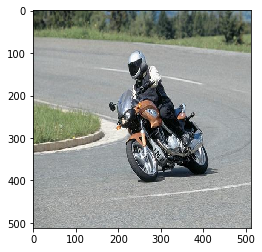

In [13]:
plt.imshow(im)
print(np.asarray(im).shape)

In [14]:
imarr=np.array(im).astype(np.float32)
imarr.shape
print(imarr)

[[[ 52.  64.  52.]
  [ 50.  62.  50.]
  [ 48.  60.  50.]
  ...
  [113. 143. 169.]
  [111. 141. 167.]
  [108. 138. 164.]]

 [[ 47.  59.  47.]
  [ 47.  59.  47.]
  [ 48.  60.  50.]
  ...
  [115. 145. 169.]
  [112. 142. 166.]
  [110. 140. 164.]]

 [[ 47.  59.  47.]
  [ 47.  59.  47.]
  [ 48.  60.  50.]
  ...
  [115. 145. 169.]
  [112. 142. 166.]
  [110. 140. 164.]]

 ...

 [[161. 163. 160.]
  [178. 180. 177.]
  [186. 188. 185.]
  ...
  [141. 146. 142.]
  [145. 150. 146.]
  [155. 160. 156.]]

 [[161. 163. 160.]
  [178. 180. 177.]
  [186. 188. 185.]
  ...
  [141. 146. 142.]
  [145. 150. 146.]
  [155. 160. 156.]]

 [[147. 149. 146.]
  [160. 162. 159.]
  [163. 165. 162.]
  ...
  [174. 176. 171.]
  [177. 179. 174.]
  [187. 189. 184.]]]


In [15]:
from scipy.io import loadmat
path=os.path.expanduser(os.path.join('~', '.keras/models/pascal-fcn16s-dag'))
data = loadmat(path, matlab_compatible=False, struct_as_record=False)


In [16]:
data.keys()
layers=data['layers']
params=data['params']
description=data['meta'][0,0].classes[0,0].description
description


array([[array(['background'], dtype='<U10'),
        array(['aeroplane'], dtype='<U9'),
        array(['bicycle'], dtype='<U7'), array(['bird'], dtype='<U4'),
        array(['boat'], dtype='<U4'), array(['bottle'], dtype='<U6'),
        array(['bus'], dtype='<U3'), array(['car'], dtype='<U3'),
        array(['cat'], dtype='<U3'), array(['chair'], dtype='<U5'),
        array(['cow'], dtype='<U3'),
        array(['diningtable'], dtype='<U11'),
        array(['dog'], dtype='<U3'), array(['horse'], dtype='<U5'),
        array(['motorbike'], dtype='<U9'),
        array(['person'], dtype='<U6'),
        array(['pottedplant'], dtype='<U11'),
        array(['sheep'], dtype='<U5'), array(['sofa'], dtype='<U4'),
        array(['train'], dtype='<U5'), array(['tvmonitor'], dtype='<U9')]],
      dtype=object)

In [17]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [18]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, params.shape[1]-1, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [19]:

copy_mat_to_keras(fcn)

found :  ('conv1_1', 1)
(3, 3, 3, 64) (3, 3, 3, 64)
found :  ('conv1_2', 2)
(3, 3, 64, 64) (3, 3, 64, 64)
found :  ('conv2_1', 4)
(3, 3, 64, 128) (3, 3, 64, 128)
found :  ('conv2_2', 5)
(3, 3, 128, 128) (3, 3, 128, 128)
found :  ('conv3_1', 7)
(3, 3, 128, 256) (3, 3, 128, 256)
found :  ('conv3_2', 8)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv3_3', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv4_1', 11)
(3, 3, 256, 512) (3, 3, 256, 512)
found :  ('conv4_2', 12)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv4_3', 13)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_1', 15)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_2', 16)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_3', 17)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('fc6', 19)
(7, 7, 512, 4096) (7, 7, 512, 4096)
found :  ('fc7', 21)
(1, 1, 4096, 4096) (1, 1, 4096, 4096)
found :  ('score_fr', 23)
(1, 1, 4096, 21) (1, 1, 4096, 21)
found :  ('score2', 24)
(4, 4, 21, 21) (4, 4, 21, 21)
found :  ('score_pool4

In [20]:
imarr=np.expand_dims(imarr,axis=0)

In [21]:
fcn.load_weights(weights_path,by_name=True)

In [22]:
preds=fcn.predict(imarr)

In [23]:
print(preds.shape)

(1, 512, 512, 21)


In [24]:
imclass=np.argmax(preds,axis=3)[0,:,:]
print(imclass)

[[18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


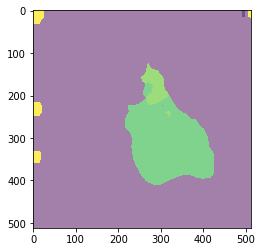

In [25]:

plt.imshow(imclass,alpha=0.5)

masked_class=np.ma.masked_where(imclass==0,imclass)
plt.imshow(masked_class,alpha=0.5)

In [ ]:
import "https://github.com/mprat/pascal-voc-python/blob/master/voc_utils/voc_utils.py"

In [8]:
import sys
>>> type(sys.path)

>>> for path in sys.path:
...     print(path)


c:\users\hp\appdata\local\programs\python\python36\python36.zip
c:\users\hp\appdata\local\programs\python\python36\DLLs
c:\users\hp\appdata\local\programs\python\python36\lib
c:\users\hp\appdata\local\programs\python\python36
C:\Users\Hp\AppData\Roaming\Python\Python36\site-packages
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\voc_utils-0.0-py3.6.egg
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\more_itertools-4.3.0-py3.6.egg
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\beautifulsoup4-4.3.2-py3.6.egg
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\IPython\extensions
C:\Users\Hp\.ipython


In [9]:
sys.path.append('C:/Users/Hp/kerascontrib/keras_contrib/datasets')

In [10]:
import pascal_voc as p

Using TensorFlow backend.


In [11]:
p.pascal_segmentation_lut()

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'potted-plant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv/monitor',
 255: 'ambigious'}

In [15]:
pascal_root='C:/Users/Hp/.keras/datasets/VOC2012/VOCdevkit/VOC2012'

In [16]:
p.get_pascal_segmentation_images_lists_txts(pascal_root)

['C:/Users/Hp/.keras/datasets/VOC2012/VOCdevkit/VOC2012\\ImageSets/Segmentation\\train.txt',
 'C:/Users/Hp/.keras/datasets/VOC2012/VOCdevkit/VOC2012\\ImageSets/Segmentation\\val.txt',
 'C:/Users/Hp/.keras/datasets/VOC2012/VOCdevkit/VOC2012\\ImageSets/Segmentation\\trainval.txt']

In [17]:
p.readlines_with_strip(pascal_root)

PermissionError: [Errno 13] Permission denied: 'C:/Users/Hp/.keras/datasets/VOC2012/VOCdevkit/VOC2012'

In [19]:
arr=p.get_pascal_segmentation_image_annotation_filenames_pairs(pascal_root)

